In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import metrics
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 全文忽略警告
import warnings
warnings.filterwarnings("ignore")

In [92]:
pd.set_option('display.max_columns',None)    # 显示所有列
pd.set_option('display.max_row',None)        # 显示所有行
pd.set_option('display.max_colwidth',1000)   # 打印不换行

# 一、导入数据和数据处理

In [3]:
# 数据导入和数据处理
all_data = pd.read_csv('./num_predict.csv')
all_data = all_data[~(all_data['numbers']==1)]
all_data['year'] = all_data['date'].map(lambda x: x.split('-')[0])
all_data['mon_day'] = all_data['date'].map(lambda x: x[5:])

# 保证每年的数据在相同的时间段内
everYear_min_date, everYear_max_date = [], []
for k in all_data['year'].unique():
    i_data = all_data[all_data['year']==k]
    everYear_min_date.append(min(i_data['mon_day']))
    everYear_max_date.append(max(i_data['mon_day']))
all_data = all_data[(all_data['mon_day']>=max(everYear_min_date)) & (all_data['mon_day']<=min(everYear_max_date))]
all_data.set_index('date',inplace=True)

# all_data.rename({'numbers': 'y'},axis='columns',inplace=True)
# all_data.insert(all_data.shape[1], 'store_code', 1)

print(all_data.shape)
all_data.head()

(192, 3)


,numbers,year,mon_day
date,,,
2016-09-06,22.0,2016,09-06
2016-09-07,26.0,2016,09-07
2016-09-08,29.0,2016,09-08
2016-09-09,24.0,2016,09-09
2016-09-10,35.0,2016,09-10


In [4]:
# 2016-2020的数据
data_2016_2020 = list(all_data[~(all_data['year']=='2021')]['numbers'].values)
data_2d_2016_2020 = all_data[~(all_data['year']=='2021')]
# 2021的数据
data_2021 = list(all_data[all_data['year']=='2021']['numbers'].values)
# 全部数据
all_data_list = list(all_data['numbers'].values)

In [5]:
data_2d_2016_2020.head()

,numbers,year,mon_day
date,,,
2016-09-06,22.0,2016,09-06
2016-09-07,26.0,2016,09-07
2016-09-08,29.0,2016,09-08
2016-09-09,24.0,2016,09-09
2016-09-10,35.0,2016,09-10


# 二、数据分析

## 2.1、判断数据是否平稳

In [6]:
#数据平稳性检测 因为只有平稳数据才能做时间序列分析————原理待研究
def judge_stationarity(data_sanya_one):
    dftest = ts.adfuller(data_sanya_one)
    print(dftest)
    stationarity = 1
    for key, value in dftest[4].items():
        if dftest[0] > value:
                stationarity = 0
    # 若ADF值同时小于critical-value中1%，5%，10%对应的值，则说明数据平稳。
    print("是否平稳(1/0): %d" %(stationarity))

stationarity = judge_stationarity(data_2016_2020)

(-5.804427549973745, 4.551368138028973e-07, 0, 159, {'1%': -3.472161410886292, '5%': -2.8798954259680936, '10%': -2.5765565828092245}, 1150.3699019251258)
是否平稳(1/0): 1


In [ ]:
### 数据不平稳则进行差分处理 ###

# 对数据差分
# diff1 = timeseries.diff(1).dropna()  # 1阶差分
# 再进行平稳性判断
# adftest_diff1 = adfuller(diff1,autolag = 'AIC')

## 若1阶差分不能使数据平稳，则继续2阶差分，以此类推（也可以在一阶差分的基础上再进行一阶差分）
# diff2 = timeseries.diff(2).dropna()  # 1阶差分
# 再进行平稳性判断
# adftest_diff2 = adfuller(diff2,autolag = 'AIC')

## 2.2、季节性分析

<Figure size 432x288 with 0 Axes>

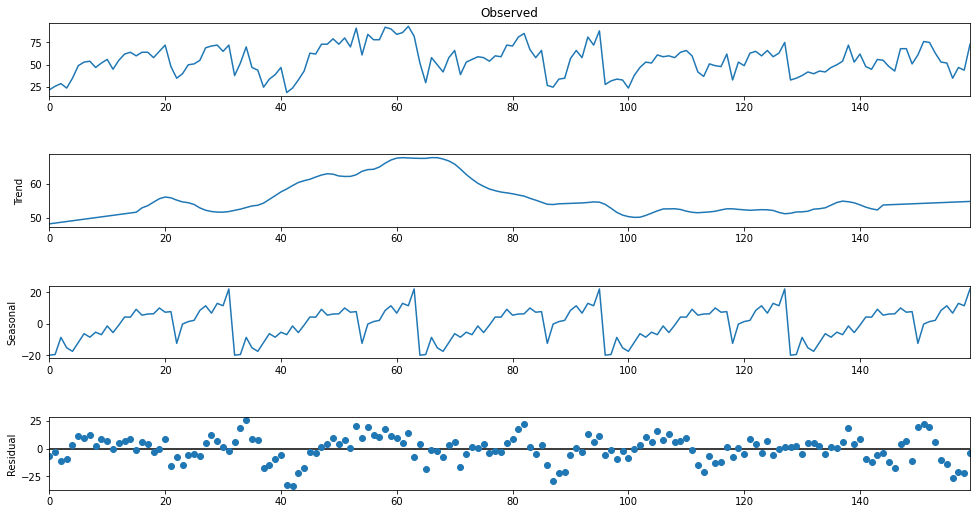

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_2d_2016_2020.numbers.values, period=32, extrapolate_trend='freq')
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

# 三、确定参数

## 3.1、order确认

### 3.1.1、画图法

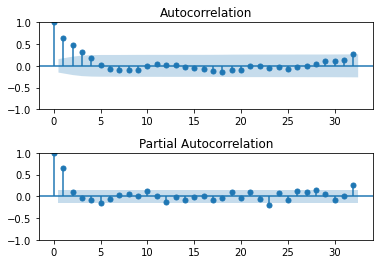

In [47]:
# 画ACF和PACF图，以确定p、q

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
 
def draw_acf_pacf(ts,lags):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts,ax=ax1,lags=lags)  #lags 表示滞后的阶数，值为30，显示30阶的图像
    ax2 = f.add_subplot(212)
    plot_pacf(ts,ax=ax2,lags=lags)  
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    
draw_acf_pacf(data_2d_2016_2020['numbers'],32)

ACF图中，自第三阶之后，数值基本落在2倍标准差范围内，所以q值应选择3

PACF图中，自第一阶之后，数值基本落在2倍标准差范围内，所以p值应选择1

### 3.1.2、aic/bic最小值法

In [94]:
#对模型p,q进行定阶
warnings.filterwarnings("ignore") # specify to ignore warning messages
from statsmodels.tsa.arima_model import ARIMA 
 
pmax = int(6)    #一般阶数不超过 length /10
qmax = int(6)
bic_matrix = []
for p in range(pmax +1):
    temp= []
    for q in range(qmax+1):
        try:
            temp.append(sm.tsa.arima.ARIMA(data_2d_2016_2020['numbers'].values, order=(p, 0, q)).fit().aic)
        except:
            temp.append(None)
    bic_matrix.append(temp)

# print(bic_matrix)
bic_matrix = pd.DataFrame(bic_matrix)   #将其转换成Dataframe 数据结构
# print(bic_matrix)
# print(bic_matrix.head().stack())
# print(bic_matrix.head().stack().sort_values(ascending=False))
# print(bic_matrix.head().stack().idxmin())
p,q = bic_matrix.stack().idxmin()   #先使用stack 展平， 然后使用 idxmin 找出最小值的位置
# print(u'BIC 最小的p值 和 q 值：%s,%s' %(p,q))  #  BIC 最小的p值 和 q 值：0,1
print(p,q)

3 3


In [89]:
print(sm.tsa.arima.ARIMA(data_2d_2016_2020['numbers'].values, order=(1, 0, 3)).fit().aic)
print(sm.tsa.arima.ARIMA(data_2d_2016_2020['numbers'].values, order=(3, 0, 3)).fit().aic)

1267.4958596168983
1262.9486346126678


## 3.1、seasonal_order确认（网格搜索）

In [110]:
# 通过网格搜索对seasonal_order进行定阶,目前就是pdq=611，seasonal_order=2, 2, 1, 52效果比较好，RMSE=202.4582
# x(2, 2, 2, 32)12 - AIC: 486.94939498219276
# x(2, 2, 3, 32)12 - AIC: 244.19566876431344
# x(2, 3, 3, 32)12 - AIC: 26.0 pbq(6,1,1)
# x(3, 3, 3, 32)12 - AIC: 28.0
# x(2, 3, 3, 32)12 - AIC: 20.0 pbq(1,0,3)

# 参数选择待确认
def get_ARIMA_params(data, pdq, m=12):
    p = d = q = range(0, 3)
    seasonal_pdq = [(x[0], x[1], x[2], m) for x in list(itertools.product(p, d, q))]
    score_aic = 1000000.0
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(data,
                                        order=pdq,
                                        seasonal_order=param_seasonal)
        results = mod.fit()
        print('x{}12 - AIC:{}'.format(param_seasonal, results.aic))
        if results.aic < score_aic:
            score_aic = results.aic
            params = param_seasonal, results.aic
    # param_seasonal, results.aic = params
    # print('x{}12 - AIC:{}'.format(param_seasonal, results.aic))

    return params


# pdq = [1, 0, 3]
pdq = [3, 0, 3]
param_seasonal, aic_= get_ARIMA_params(data_2d_2016_2020['numbers'], pdq, m=32)
print(param_seasonal, aic_)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32007D+01    |proj g|=  1.87886D+01

At iterate    5    f=  4.02308D+00    |proj g|=  1.38741D-01

At iterate   10    f=  3.98648D+00    |proj g|=  1.44923D-02

At iterate   15    f=  3.98463D+00    |proj g|=  1.08791D-03

At iterate   20    f=  3.98424D+00    |proj g|=  3.74119D-03

At iterate   25    f=  3.98319D+00    |proj g|=  4.04216D-02

At iterate   30    f=  3.97750D+00    |proj g|=  2.42550D-02

At iterate   35    f=  3.97539D+00    |proj g|=  2.63001D-02

At iterate   40    f=  3.97296D+00    |proj g|=  1.26711D-01

At iterate   45    f=  3.97124D+00    |proj g|=  2.29275D-02


 This problem is unconstrained.



At iterate   50    f=  3.96929D+00    |proj g|=  6.51107D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   6.511D-02   3.969D+00
  F =   3.9692889529902979     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.03226D+01    |proj g|=  3.27188D+01

At iterate    5    f=  3.95742D+00    |proj g|=  3.97909D-02

At iterate   10    f=  3.94557D+00    |proj g|=  1.17447D-02

At iterate   15    f=  3.94365D+00    |proj g|=  3.51725D-03

At iterate   20    f=  3.94238D+00    |proj g|=  1.01807D-02

At iterate   25    f=  3.94131D+00    |proj g|=  1.44104D-02

At iterate   30    f=  3.93677D+00    |proj g|=  5.98923D-02

At iterate   35    f=  3.93373D+00    |proj g|=  9.22514D-02

At iterate   40    f=  3.93252D+00    |proj g|=  4.19402D-02

At iterate   45    f=  3.93003D+00    |proj g|=  3.07016D-03

At iterate   50    f=  3.92985D+00    |proj g|=  1.47378D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32007D+01    |proj g|=  1.87886D+01

At iterate    5    f=  3.96005D+00    |proj g|=  1.00506D-01

At iterate   10    f=  3.92906D+00    |proj g|=  1.49672D-02

At iterate   15    f=  3.92735D+00    |proj g|=  4.55754D-03

At iterate   20    f=  3.92700D+00    |proj g|=  1.19137D-03

At iterate   25    f=  3.92692D+00    |proj g|=  5.29747D-03

At iterate   30    f=  3.92533D+00    |proj g|=  4.24544D-02

At iterate   35    f=  3.90551D+00    |proj g|=  2.89500D-02

At iterate   40    f=  3.89790D+00    |proj g|=  3.82024D-03

At iterate   45    f=  3.89641D+00    |proj g|=  9.49630D-03

At iterate   50    f=  3.89613D+00    |proj g|=  4.15055D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27157D+00    |proj g|=  4.05734D-02

At iterate    5    f=  3.26947D+00    |proj g|=  8.89251D-03

At iterate   10    f=  3.26910D+00    |proj g|=  1.02056D-03

At iterate   15    f=  3.26902D+00    |proj g|=  8.16672D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     21      1     0     0   5.930D-05   3.269D+00
  F =   3.2690226276610126     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27157D+00    |proj g|=  2.89078D-01

At iterate    5    f=  3.17807D+00    |proj g|=  2.00003D-02

At iterate   10    f=  3.14872D+00    |proj g|=  3.91767D-02

At iterate   15    f=  3.14512D+00    |proj g|=  4.93893D-03

At iterate   20    f=  3.14433D+00    |proj g|=  3.53147D-03

At iterate   25    f=  3.14417D+00    |proj g|=  5.89125D-03

At iterate   30    f=  3.14400D+00    |proj g|=  2.38497D-03

At iterate   35    f=  3.14399D+00    |proj g|=  3.96454D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27157D+00    |proj g|=  2.89078D-01

At iterate    5    f=  3.17823D+00    |proj g|=  1.98927D-02

At iterate   10    f=  3.15293D+00    |proj g|=  3.67176D-02

At iterate   15    f=  3.14531D+00    |proj g|=  3.02085D-03

At iterate   20    f=  3.14434D+00    |proj g|=  1.12972D-03

At iterate   25    f=  3.14425D+00    |proj g|=  3.04390D-03

At iterate   30    f=  3.14401D+00    |proj g|=  2.51870D-03

At iterate   35    f=  3.14391D+00    |proj g|=  1.28105D-03

At iterate   40    f=  3.14382D+00    |proj g|=  7.11243D-04

At iterate   45    f=  3.14382D+00    |proj g|=  7.61454D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77918D+00    |proj g|=  4.03139D-02

At iterate    5    f=  2.77507D+00    |proj g|=  2.86697D-02

At iterate   10    f=  2.77370D+00    |proj g|=  7.20380D-03

At iterate   15    f=  2.77079D+00    |proj g|=  1.83805D-03

At iterate   20    f=  2.77078D+00    |proj g|=  1.91711D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     24      1     0     0   2.902D-05   2.771D+00
  F =   2.7707788947314218     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  2.68615D+00    |proj g|=  1.11582D-02

At iterate   10    f=  2.68264D+00    |proj g|=  2.37825D-02

At iterate   15    f=  2.67008D+00    |proj g|=  4.61884D-03

At iterate   20    f=  2.66555D+00    |proj g|=  7.43755D-03

At iterate   25    f=  2.66546D+00    |proj g|=  5.95837D-04

At iterate   30    f=  2.66531D+00    |proj g|=  2.98588D-03

At iterate   35    f=  2.66528D+00    |proj g|=  5.20979D-04

At iterate   40    f=  2.66527D+00    |proj g|=  3.49586D-04

At iterate   45    f=  2.66527D+00    |proj g|=  8.79466D-04

At iterate   50    f=  2.66523D+00    |proj g|=  1.35188D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.67656D+00    |proj g|=  9.79151D-03

At iterate   10    f=  2.66929D+00    |proj g|=  4.08118D-02

At iterate   15    f=  2.65372D+00    |proj g|=  2.79039D-03

At iterate   20    f=  2.65358D+00    |proj g|=  2.00181D-03

At iterate   25    f=  2.65356D+00    |proj g|=  5.94442D-05

At iterate   30    f=  2.65355D+00    |proj g|=  1.59210D-04

At iterate   35    f=  2.65355D+00    |proj g|=  1.40516D-04

At iterate   40    f=  2.65355D+00    |proj g|=  4.28989D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     47      1     0     0   3.041D-05   2.654D+00
  F =   2.65355389126

 This problem is unconstrained.



At iterate    5    f=  4.14672D+00    |proj g|=  8.35283D-02

At iterate   10    f=  3.96958D+00    |proj g|=  1.14735D-01

At iterate   15    f=  3.93690D+00    |proj g|=  1.68628D-02

At iterate   20    f=  3.93444D+00    |proj g|=  9.66070D-03

At iterate   25    f=  3.93240D+00    |proj g|=  1.37523D-03

At iterate   30    f=  3.93176D+00    |proj g|=  2.68070D-02

At iterate   35    f=  3.93136D+00    |proj g|=  9.87324D-04

At iterate   40    f=  3.93047D+00    |proj g|=  1.88351D-02

At iterate   45    f=  3.92822D+00    |proj g|=  2.30918D-02

At iterate   50    f=  3.92532D+00    |proj g|=  2.44853D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.94491D+00    |proj g|=  6.20785D-02

At iterate   10    f=  3.92624D+00    |proj g|=  1.12672D-02

At iterate   15    f=  3.92157D+00    |proj g|=  1.42887D-02

At iterate   20    f=  3.91922D+00    |proj g|=  9.60082D-04

At iterate   25    f=  3.91874D+00    |proj g|=  9.66865D-03

At iterate   30    f=  3.91826D+00    |proj g|=  3.99176D-03

At iterate   35    f=  3.91711D+00    |proj g|=  2.96451D-02

At iterate   40    f=  3.91531D+00    |proj g|=  1.64856D-02

At iterate   45    f=  3.91422D+00    |proj g|=  9.71636D-03

At iterate   50    f=  3.91327D+00    |proj g|=  2.37738D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.95350D+00    |proj g|=  7.68561D-02

At iterate   10    f=  3.93100D+00    |proj g|=  1.05277D-02

At iterate   15    f=  3.92572D+00    |proj g|=  1.15350D-02

At iterate   20    f=  3.92373D+00    |proj g|=  5.25933D-03

At iterate   25    f=  3.92117D+00    |proj g|=  1.65087D-02

At iterate   30    f=  3.91922D+00    |proj g|=  2.43186D-02

At iterate   35    f=  3.91770D+00    |proj g|=  1.01501D-02

At iterate   40    f=  3.91707D+00    |proj g|=  2.44646D-03

At iterate   45    f=  3.91683D+00    |proj g|=  5.21758D-03

At iterate   50    f=  3.91485D+00    |proj g|=  1.01163D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20770D+00    |proj g|=  4.19311D-02

At iterate    5    f=  3.20053D+00    |proj g|=  1.34925D-02

At iterate   10    f=  3.19392D+00    |proj g|=  2.43098D-03

At iterate   15    f=  3.19367D+00    |proj g|=  8.05286D-04

At iterate   20    f=  3.19364D+00    |proj g|=  2.59346D-03

At iterate   25    f=  3.19276D+00    |proj g|=  1.20846D-02

At iterate   30    f=  3.18874D+00    |proj g|=  1.00946D-02

At iterate   35    f=  3.18684D+00    |proj g|=  9.77132D-03

At iterate   40    f=  3.18452D+00    |proj g|=  5.07604D-03

At iterate   45    f=  3.18363D+00    |proj g|=  5.67040D-03

At iterate   50    f=  3.18252D+00    |proj g|=  1.22486D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25395D+00    |proj g|=  2.49338D-01

At iterate    5    f=  3.17807D+00    |proj g|=  2.67086D-02

At iterate   10    f=  3.14823D+00    |proj g|=  4.23503D-02

At iterate   15    f=  3.14566D+00    |proj g|=  7.16946D-03

At iterate   20    f=  3.14427D+00    |proj g|=  1.38168D-03

At iterate   25    f=  3.14418D+00    |proj g|=  3.03740D-03

At iterate   30    f=  3.14390D+00    |proj g|=  3.59028D-04

At iterate   35    f=  3.14390D+00    |proj g|=  1.23834D-04

At iterate   40    f=  3.14389D+00    |proj g|=  7.76930D-04

At iterate   45    f=  3.14386D+00    |proj g|=  4.06176D-04

At iterate   50    f=  3.14385D+00    |proj g|=  3.15519D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.17840D+00    |proj g|=  1.71019D-02

At iterate   10    f=  3.15368D+00    |proj g|=  1.96887D-02

At iterate   15    f=  3.14466D+00    |proj g|=  3.85080D-03

At iterate   20    f=  3.14431D+00    |proj g|=  6.10960D-03

At iterate   25    f=  3.14376D+00    |proj g|=  2.02803D-03

At iterate   30    f=  3.14333D+00    |proj g|=  4.62514D-03

At iterate   35    f=  3.14324D+00    |proj g|=  8.23773D-04

At iterate   40    f=  3.14316D+00    |proj g|=  2.06618D-04

At iterate   45    f=  3.14315D+00    |proj g|=  1.83886D-04

At iterate   50    f=  3.14311D+00    |proj g|=  2.36447D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.67877D+00    |proj g|=  7.09000D-03

At iterate   10    f=  2.66525D+00    |proj g|=  1.34315D-02

At iterate   15    f=  2.66406D+00    |proj g|=  3.53906D-03

At iterate   20    f=  2.66398D+00    |proj g|=  2.13189D-04

At iterate   25    f=  2.66397D+00    |proj g|=  1.71900D-03

At iterate   30    f=  2.66396D+00    |proj g|=  6.09266D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     31     36      1     0     0   2.925D-05   2.664D+00
  F =   2.6639576616971903     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.67694D+00    |proj g|=  7.74154D-03

At iterate   10    f=  2.67224D+00    |proj g|=  1.77625D-02

At iterate   15    f=  2.65598D+00    |proj g|=  1.13963D-02

At iterate   20    f=  2.65427D+00    |proj g|=  2.08127D-03

At iterate   25    f=  2.65377D+00    |proj g|=  1.30515D-03

At iterate   30    f=  2.65374D+00    |proj g|=  3.12363D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     33     36      1     0     0   1.981D-05   2.654D+00
  F =   2.6537417128795346     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77918D+00    |proj g|=  3.12559D-01

At iterate    5    f=  2.67786D+00    |proj g|=  1.28222D-02

At iterate   10    f=  2.67383D+00    |proj g|=  1.64708D-02

At iterate   15    f=  2.65480D+00    |proj g|=  1.91315D-02

At iterate   20    f=  2.65371D+00    |proj g|=  2.73912D-03

At iterate   25    f=  2.65365D+00    |proj g|=  8.76607D-04

At iterate   30    f=  2.65364D+00    |proj g|=  7.65362D-04

At iterate   35    f=  2.65358D+00    |proj g|=  9.52188D-04

At iterate   40    f=  2.65353D+00    |proj g|=  1.08668D-03

At iterate   45    f=  2.65351D+00    |proj g|=  2.43407D-04

At iterate   50    f=  2.65350D+00    |proj g|=  7.36162D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.88013D+00    |proj g|=  2.00478D+00

At iterate    5    f=  3.98147D+00    |proj g|=  1.50773D-01

At iterate   10    f=  3.92944D+00    |proj g|=  1.67643D-02

At iterate   15    f=  3.92527D+00    |proj g|=  2.47189D-02

At iterate   20    f=  3.92354D+00    |proj g|=  1.01331D-03

At iterate   25    f=  3.92341D+00    |proj g|=  1.08951D-03

At iterate   30    f=  3.92335D+00    |proj g|=  4.45184D-03

At iterate   35    f=  3.92235D+00    |proj g|=  2.45826D-02

At iterate   40    f=  3.92006D+00    |proj g|=  2.13384D-02

At iterate   45    f=  3.91717D+00    |proj g|=  7.54552D-02

At iterate   50    f=  3.91573D+00    |proj g|=  4.49237D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.94441D+00    |proj g|=  6.14368D-02

At iterate   10    f=  3.92722D+00    |proj g|=  1.42805D-02

At iterate   15    f=  3.92212D+00    |proj g|=  2.30666D-02

At iterate   20    f=  3.91941D+00    |proj g|=  1.50657D-03

At iterate   25    f=  3.91893D+00    |proj g|=  1.35334D-02

At iterate   30    f=  3.91798D+00    |proj g|=  4.79111D-03

At iterate   35    f=  3.91662D+00    |proj g|=  4.05016D-02

At iterate   40    f=  3.91505D+00    |proj g|=  1.23251D-02

At iterate   45    f=  3.91419D+00    |proj g|=  5.38145D-02

At iterate   50    f=  3.91348D+00    |proj g|=  1.33134D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32007D+01    |proj g|=  1.87886D+01

At iterate    5    f=  3.95127D+00    |proj g|=  6.50862D-02

At iterate   10    f=  3.92904D+00    |proj g|=  1.08495D-02

At iterate   15    f=  3.92493D+00    |proj g|=  5.31398D-02

At iterate   20    f=  3.91979D+00    |proj g|=  3.51889D-03

At iterate   25    f=  3.91906D+00    |proj g|=  1.19056D-02

At iterate   30    f=  3.91817D+00    |proj g|=  5.65351D-03

At iterate   35    f=  3.91811D+00    |proj g|=  2.09134D-03

At iterate   40    f=  3.91791D+00    |proj g|=  8.66534D-03

At iterate   45    f=  3.91707D+00    |proj g|=  2.31365D-02

At iterate   50    f=  3.91581D+00    |proj g|=  4.57909D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19917D+00    |proj g|=  1.13779D-01

At iterate    5    f=  3.18275D+00    |proj g|=  2.69994D-02

At iterate   10    f=  3.16923D+00    |proj g|=  2.34455D-02

At iterate   15    f=  3.16815D+00    |proj g|=  5.97672D-03

At iterate   20    f=  3.16789D+00    |proj g|=  1.67823D-04

At iterate   25    f=  3.16789D+00    |proj g|=  9.43481D-04

At iterate   30    f=  3.16785D+00    |proj g|=  5.15767D-04

At iterate   35    f=  3.16785D+00    |proj g|=  3.51240D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23841D+00    |proj g|=  2.53381D-01

At iterate    5    f=  3.17744D+00    |proj g|=  3.31618D-02

At iterate   10    f=  3.15585D+00    |proj g|=  3.26762D-02

At iterate   15    f=  3.14139D+00    |proj g|=  4.72442D-03

At iterate   20    f=  3.14085D+00    |proj g|=  7.24903D-03

At iterate   25    f=  3.14067D+00    |proj g|=  8.61715D-04

At iterate   30    f=  3.14038D+00    |proj g|=  2.30220D-03

At iterate   35    f=  3.14035D+00    |proj g|=  8.23114D-04

At iterate   40    f=  3.14034D+00    |proj g|=  2.90990D-04

At iterate   45    f=  3.14032D+00    |proj g|=  1.54156D-03

At iterate   50    f=  3.14030D+00    |proj g|=  5.50640D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.17933D+00    |proj g|=  1.63152D-02

At iterate   10    f=  3.15954D+00    |proj g|=  2.33011D-02

At iterate   15    f=  3.14527D+00    |proj g|=  5.56538D-03

At iterate   20    f=  3.14348D+00    |proj g|=  5.63896D-03

At iterate   25    f=  3.14257D+00    |proj g|=  8.43149D-03

At iterate   30    f=  3.13638D+00    |proj g|=  2.35274D-02

At iterate   35    f=  3.13488D+00    |proj g|=  4.12872D-03

At iterate   40    f=  3.13460D+00    |proj g|=  3.54075D-03

At iterate   45    f=  3.13414D+00    |proj g|=  1.14071D-03

At iterate   50    f=  3.13412D+00    |proj g|=  1.89506D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.67508D+00    |proj g|=  7.81004D-03

At iterate   10    f=  2.65701D+00    |proj g|=  2.16042D-02

At iterate   15    f=  2.65363D+00    |proj g|=  1.65347D-03

At iterate   20    f=  2.65351D+00    |proj g|=  2.07675D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     23     26      1     0     0   1.113D-05   2.654D+00
  F =   2.6535101789521836     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.67673D+00    |proj g|=  7.69365D-03

At iterate   10    f=  2.66769D+00    |proj g|=  3.00427D-02

At iterate   15    f=  2.65365D+00    |proj g|=  2.15426D-03

At iterate   20    f=  2.65355D+00    |proj g|=  2.09919D-03

At iterate   25    f=  2.65353D+00    |proj g|=  3.75414D-04

At iterate   30    f=  2.65351D+00    |proj g|=  5.49514D-04

At iterate   35    f=  2.65344D+00    |proj g|=  2.11486D-03

At iterate   40    f=  2.65334D+00    |proj g|=  7.41826D-04

At iterate   45    f=  2.65331D+00    |proj g|=  6.68274D-04

At iterate   50    f=  2.65329D+00    |proj g|=  1.00268D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.67794D+00    |proj g|=  7.88923D-03

At iterate   10    f=  2.67192D+00    |proj g|=  1.54290D-02

At iterate   15    f=  2.65626D+00    |proj g|=  4.70493D-02

At iterate   20    f=  2.65340D+00    |proj g|=  1.01452D-03

At iterate   25    f=  2.65327D+00    |proj g|=  9.02466D-04

At iterate   30    f=  2.65326D+00    |proj g|=  1.30795D-03

At iterate   35    f=  2.65317D+00    |proj g|=  3.84896D-03

At iterate   40    f=  2.65310D+00    |proj g|=  5.28766D-03

At iterate   45    f=  2.65300D+00    |proj g|=  6.56788D-04

At iterate   50    f=  2.65297D+00    |proj g|=  1.72939D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [113]:
print(param_seasonal, aic_)

(2, 2, 0, 32) 867.1232572646987


# 四、预测

In [1]:
mod = sm.tsa.statespace.SARIMAX(data_2d_2016_2020['numbers'],
                                order=(3,0,3),
                                seasonal_order=param_seasonal,
                                trend='t')
results = mod.fit()

NameError: name 'sm' is not defined

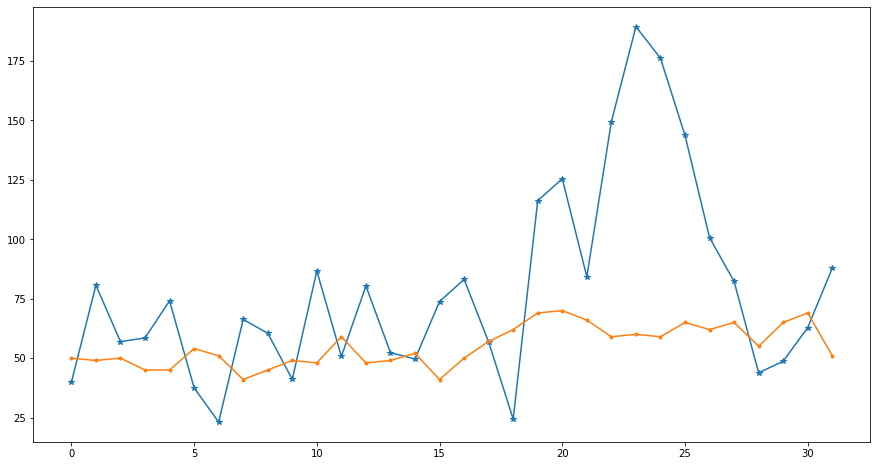

In [123]:
predict_ts = results.predict(tpy='levels')  #tpy='levels'直接预测值，没有的话预测的是差值
plt.figure(figsize=(15, 8))
l3, = plt.plot(list(results.forecast(32)), marker='*')
l4, = plt.plot(data_2021, marker='.')
plt.show()

# 五、评分

In [120]:
def mape_fun(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

def smape_fun(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

def assess(predict_data):
    # 均方误差
    mse = metrics.mean_squared_error(data_2021, predict_data)
    print('均方误差MSE:', mse)
    # 均方根误差
    rmse = np.sqrt(metrics.mean_squared_error(data_2021, predict_data))
    print('均方根误差RMSE:', rmse)
    # 平均绝对误差
    mae = metrics.mean_absolute_error(data_2021, predict_data)
    print('平均绝对误差MAE:', mae)
    # 平均绝对百分比误差
    mape = mape_fun(data_2021, predict_data)
    print('平均绝对百分比误差MAPE:', mape)
    # 对称平均绝对百分比误差
    smape = smape_fun(data_2021, predict_data)
    print('对称平均绝对百分比误差SMAPE:', smape)

In [124]:
assess(results.forecast(32))

均方误差MSE: 2015.6453800229015
均方根误差RMSE: 44.895939460299765
平均绝对误差MAE: 32.394599556470254
平均绝对百分比误差MAPE: 57.86603481530763
对称平均绝对百分比误差SMAPE: 43.00627266322067
